## 1. 분석 목표

본 분석의 목표는 **Resort Hotel**의 예약 데이터를 사용하여 고객의 특성을 깊이 있게 이해하고, 비즈니스 인사이트를 도출하는 데 있다. 구체적인 목표는 다음과 같다.

1.  **기술적 고객 세분화 (Customer Segmentation):** 고객의 예약 행동 및 인구통계학적 특성을 기반으로 군집화를 진행하여, 서로 다른 특성을 가진 고객 그룹(페르소나)을 정의한다. 이는 타겟 마케팅 전략 수립 및 맞춤형 서비스 제공의 기반이 된다.
2.  **예약 취소 예측 모델링:** 고객의 예약 정보와 행동 패턴을 분석하여 예약 취소 가능성을 예측하는 분류 모델을 구축한다. 이를 통해 잠재적 취소 고객을 사전에 식별하고, 취소 방지를 위한 선제적 대응(프로모션 제공 등)을 가능하게 한다.

**추가 분석 및 시각화**: `plotly` 라이브러리를 활용하여 클러스터별 특징을 더욱 풍부하게 시각화하여 비즈니스 인사이트 도출을 강화합니다.

## 2. 분석 프로세스 개요

분석은 다음과 같은 6단계의 구조화된 프로세스로 진행된다.

1.  **EDA (탐색적 데이터 분석):** 데이터의 구조, 분포, 변수 간 관계를 파악하여 데이터에 대한 근본적인 이해를 높인다.
2.  **데이터 전처리:** 분석 목적에 맞게 데이터를 정제하고, 파생 변수를 생성하며, 모델링에 적합한 형태로 가공한다.
3.  **가설 검정:** 데이터 기반의 통계적 가설을 설정하고 검정하여, 유의미한 비즈니스 인사이트를 도출한다.
4.  **고객 클러스터링:** 비지도 학습 기법을 사용하여 고객을 유사한 특성을 가진 그룹으로 분류하고, 각 그룹의 페르소나를 정의한다.
5.  **시각화:** 분석 과정에서 발견한 주요 인사이트와 클러스터링, 모델링 결과를 효과적으로 전달하기 위한 시각 자료를 생성한다.
6.  **모델링 (예약 취소 예측):** 지도 학습 알고리즘을 사용하여 예약 취소 여부를 예측하는 모델을 구축하고 성능을 평가한다.

## 3. 세부 분석 계획

### 3.1. EDA (탐색적 데이터 분석)

데이터의 잠재적 패턴과 이상 징후를 초기에 발견하기 위한 단계이다.

#### 3.1.0. 모듈 및 폰트 설정

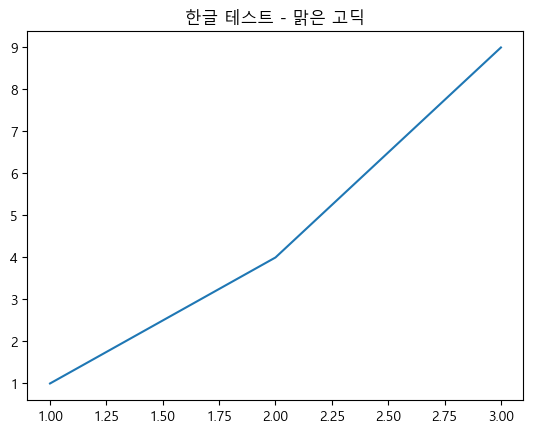

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기본)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

plt.plot([1,2,3],[1,4,9])
plt.title("한글 테스트 - 맑은 고딕")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#### 3.1.1. 데이터 로드 및 기본 정보 확인

-   **수행 내용:** `pandas` 라이브러리를 사용하여 `hotel_booking.csv` 파일을 DataFrame으로 로드한다. `.info()`, `.head()`, `.describe(include='all')` 함수를 통해 데이터의 전체적인 구조, 컬럼별 데이터 타입, 결측치 유무, 기초 통계량을 확인한다.
-   **선택 근거:** 데이터 분석의 가장 첫 단계로, 데이터의 무결성(integrity)과 기본적인 특성을 파악하여 이후의 분석 계획을 구체화하는 데 필수적이다.

In [ ]:
import pandas as pd

# 같은 경로에 있는 CSV 파일 로드
file_path = 'hotel_booking.csv'
df = pd.read_csv(file_path)

df.head()

### 3.2. 데이터 전처리 (Data Preprocessing)

분석의 정확성과 모델의 성능을 극대화하기 위해 데이터를 정제하고 구조화하는 단계이다.

In [ ]:

# CSV 파일 로드
df = pd.read_csv(file_path)

df = df.drop(columns=["hotel"])

df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + " " +
    df["arrival_date_month"].astype(str) + " " +
    df["arrival_date_day_of_month"].astype(str),
    format="%Y %B %d"
)

df["booking_date"] = df["arrival_date"] - pd.to_timedelta(df["lead_time"], unit="D")

# NaN 값을 0으로 채운 후 정수형으로 변환
df["adults"] = df["adults"].fillna(0).astype(int)
df["children"] = df["children"].fillna(0).astype(int)
df["babies"] = df["babies"].fillna(0).astype(int)


df['total_guests'] = df['adults'] + df['children'] + df['babies']

df = df.drop(columns=['name', 'email','phone-number', 'credit_card'])

df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

df['is_child'] = (df['children'] > 0) | (df['babies'] > 0)

#### 3.2.3. 결측치 및 무효 데이터 처리

-   **수행 내용:**
    1.  `total_guests`가 0인 행을 제거한다. (예약에 사람이 없는 경우는 데이터 오류)
    2.  `stays_in_weekend_nights`와 `stays_in_week_nights`의 합이 0인 행을 제거한다. (최소 1박 이상 숙박해야 함)
    3.  `children`, `country`, `agent` 컬럼의 결측치(NaN)를 처리한다.
        -   `children`: 0으로 대체한다. (자녀가 없으면 비워두는 경우가 많음)
        -   `country`: 최빈값(mode)으로 대체한다. (국적 정보는 중요 변수이므로 행 삭제보다 대체가 유리)
        -   `agent`: 0으로 대체한다. (결측치는 에이전트를 통하지 않은 직접 예약을 의미할 가능성이 높음)
-   **선택 근거:** 논리적으로 유효하지 않은 데이터를 제거하여 분석 결과의 신뢰도를 높인다. 결측치는 각 변수의 특성을 고려한 합리적인 방식으로 처리하여 데이터 손실을 최소화하고, 분석의 편향을 줄인다.

In [ ]:
df[df['total_guests'] <= 0].shape

(180, 36)

In [ ]:
df[df['total_nights'] <= 0].shape

(715, 36)

In [ ]:
# total_guests가 0인 행 제거
df_cleaned = df[df['total_guests'] > 0]
df_cleaned = df_cleaned[df_cleaned['total_nights'] > 0]

#### 3.2.4. 이상치 처리 (현재 미적용, 추후 적용 계획)

-   **수행 내용:** 현재 단계에서는 이상치를 처리하지 않으나, 향후 모델 성능 저하의 원인으로 판단될 경우 적용할 수 있도록 계획을 수립한다.
-   **선택 근거:** 이상치는 실제 데이터의 중요한 특성일 수 있으므로, 무조건적인 제거는 정보 손실을 야기할 수 있다. 따라서 해당 분석에서는 그대로 두고 진행한다.

In [ ]:
# 이상치 처리 안 함